In [109]:
import nrrd
import napari
import os
import numpy as np
from skimage.segmentation import find_boundaries
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from skimage.morphology import remove_small_objects, remove_small_holes
import zarr
import scipy.ndimage
import blosc2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from helper import *
from skimage.morphology import flood

In [110]:
#Tim skinner label testing
# current_directory = os.getcwd()
# file_name = 'data/manual_1_raw.nrrd'
# file_path = os.path.join(current_directory, file_name)
# data, _ = nrrd.read(file_path)
# label_name = 'data/manual_1_label.nrrd'
# label_path = os.path.join(current_directory, label_name)
# label, _ = nrrd.read(label_path)

In [111]:
# Zarr raw block testing
scroll_name = 's1'
# s1_zarr_path = "/Volumes/16TB_RAID_0/Scroll1/Scroll1.zarr"
# s1_zarr_multi_res = zarr.open(s1_zarr_path, mode='r')
# s1_zarr = s1_zarr_multi_res[0]

x = 3500
y = 2500
z = 1000
chunk_size = 256
# zarr_data = s1_zarr[z:z+chunk_size, y:y+chunk_size, x:x+chunk_size]
# data = zarr_data

In [112]:
current_directory = os.getcwd()
save_dir = current_directory+f'/data/{x}_{y}_{z}_{scroll_name}.nrrd'
print(save_dir)
# nrrd.write(save_dir, zarr_data)

/Users/jamesdarby/Documents/VesuviusScroll/GP/Vesuvius_3D_datasets/data/3500_2500_1000_s1.nrrd


In [113]:
data, _ = nrrd.read(save_dir)

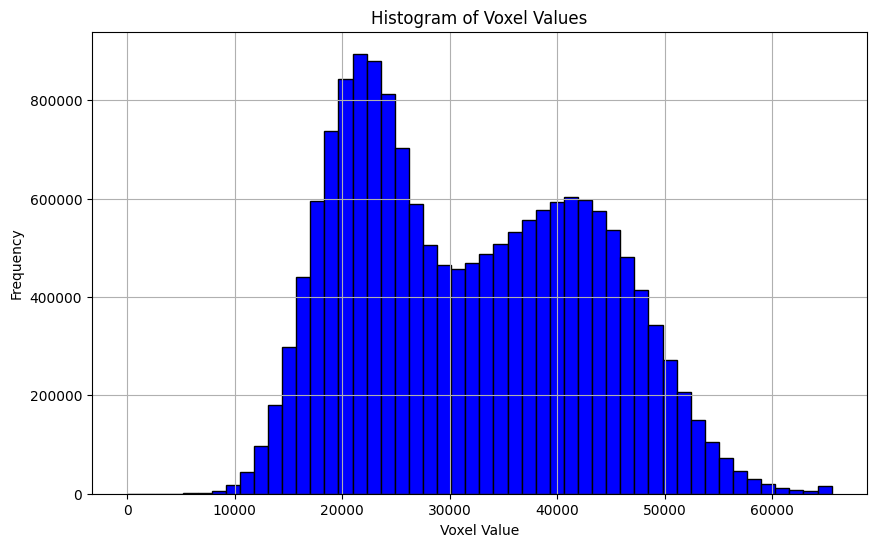

In [114]:
#Histogram of voxel values in the raw ådata
flat_data = zarr_data.flatten()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(flat_data, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Voxel Values')
plt.xlabel('Voxel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [115]:
#napari to test view the bright spots mask
# test_viewer = napari.Viewer()
# test_viewer.add_image(data, name='raw')
# test_viewer.add_labels(bright_spot_mask, name='bright spots')

# napari.run()

In [116]:
# gross volumetric labels
current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'data/s1_gross_labels.b2nd')
blosc2_full_array = blosc2.open(file_path, mode='r')

label = blosc2_full_array[z:z+chunk_size, y:y+chunk_size, x:x+chunk_size]
label = label * np.logical_not(bright_spot_mask)

In [117]:
#helper functions for napari ui
from collections import deque

def limited_bfs_flood_fill(data, start_coords, max_distance):
    shape = data.shape
    filled = np.zeros(shape, dtype=bool)
    value = data[start_coords]
    
    # Directions for 6-connectivity in 3D (x, y, z)
    directions = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
    
    # BFS queue
    queue = deque([(start_coords, 0)])  # (coordinates, distance)
    filled[start_coords] = True

    while queue:
        (z, y, x), dist = queue.popleft()
        
        if dist < max_distance:
            for dz, dy, dx in directions:
                nz, ny, nx = z + dz, y + dy, x + dx
                
                if 0 <= nz < shape[0] and 0 <= ny < shape[1] and 0 <= nx < shape[2]:
                    if not filled[nz, ny, nx] and data[nz, ny, nx] == value:
                        filled[nz, ny, nx] = True
                        queue.append(((nz, ny, nx), dist + 1))

    return filled

def label_foreground_structures_napari(input_array, min_size=1000, border_class=254):
    # Find connected components in the foreground (value 2)
    foreground = input_array > 0
    foreground[foreground == border_class] = 0

    # Label connected components
    labeled_array, num_features = scipy.ndimage.label(foreground)
    
    # Measure the size of each connected component
    structure_sizes = np.array(scipy.ndimage.sum(foreground, labeled_array, range(num_features + 1)))
    
    # Create a mask to remove small structures
    remove_mask = structure_sizes < min_size
    remove_mask[0] = 0  # Ensure the background is not removed

    # Remove small structures
    labeled_array[remove_mask[labeled_array]] = 0

    # Relabel the structures after removal
    labeled_array, num_features = scipy.ndimage.label(labeled_array > 0)

    print(f"Number of connected foreground structures before filtering: {num_features}")
    print(f"Number of connected foreground structures after filtering: {np.max(labeled_array)}")
    
    labeled_array[input_array == border_class] = border_class # Add the border class back in

    return labeled_array

def find_label_boundaries(label, labels):
    if label == 0:
        return None  # Skip background
    # Find boundaries for the current label
    label_boundaries = find_boundaries(labels == label, mode='outer')
    return label, label_boundaries

def generate_borders_view_parallel(labels):
    # Initialize the array to hold borders
    borders = np.zeros_like(labels, dtype=np.int8)
    unique_labels = np.unique(labels)

    # Use ThreadPoolExecutor for parallelizing the boundary computation
    with ThreadPoolExecutor() as executor:
        future_to_label = {executor.submit(find_label_boundaries, label, labels): label for label in unique_labels}
        
        for future in as_completed(future_to_label):
            result = future.result()
            if result is not None:
                label, label_boundaries = result
                # Combine the boundaries of all labels
                borders[label_boundaries] = -label

    return borders

def assign_random_values_segment(segment):
    unique_values = np.unique(segment)
    value_map = {val: random.randint(25, 250) for val in unique_values if val != 0}
    new_segment = np.copy(segment)
    for val, new_val in value_map.items():
        new_segment[segment == val] = new_val
    return new_segment

def split_and_assign_random_values(array, segment_size=32):
    # Ensure the input is a numpy array
    array = np.array(array)
    
    # Get the shape of the input array
    depth, height, width = array.shape
    
    # Initialize the new array with the same shape as the input array
    new_array = np.copy(array)
    
    # Iterate through each segment
    for z in range(0, depth, segment_size):
        for y in range(0, height, segment_size):
            for x in range(0, width, segment_size):
                # Define the boundaries of the segment
                z_end = min(z + segment_size, depth)
                y_end = min(y + segment_size, height)
                x_end = min(x + segment_size, width)
                
                # Extract the segment
                segment = array[z:z_end, y:y_end, x:x_end]
                
                # Assign new random values to the segment
                new_segment = assign_random_values_segment(segment)
                
                # Place the new segment back into the new array
                new_array[z:z_end, y:y_end, x:x_end] = new_segment
    
    return new_array


### Additional custom keybinds:<br>
q to decrease brush size<br>
e to increase brush size<br>
w to select label layer that was last clicked in move mode, alternatively use color picker (4)<br>
s to toggle show selected label<br>
a to decrease selected label value<br>
d to increase selected label value<br>
p to generate a label border layer for the current state, or regenerate and replace a stale one<br>
arrow keys scrub through layers<br>
r or / to toggle label visibility<br>
t to toggle borders visibility<br>

In [118]:
# Initialize the Napari viewer
viewer = napari.Viewer()

label_name = 'Labels'
data_name = 'Data'
border_name = 'Borders'
sheet_seperations_name = 'Sheet Seperations'
border_class = 254

# Add the 3D data to the viewer
image_layer =  viewer.add_image(data, colormap='gray', name=data_name)
labels_layer = viewer.add_labels(label, name=label_name)

@viewer.bind_key('l')
def chunk_mask(viewer):
    msg = 'chunk mask'
    viewer.status = msg
    print(msg)
    mask = split_and_assign_random_values(labels_layer.data)
    if border_name in viewer.layers:
        viewer.layers[border_name].data = mask
    else:
        viewer.add_labels(mask, name=border_name)

@viewer.bind_key('k')
def chunk_mask(viewer):
    msg = 'chunk mask'
    viewer.status = msg
    print(msg)
    mask = split_and_assign_random_values(labels_layer.data, segment_size=64)
    if border_name in viewer.layers:
        viewer.layers[border_name].data = mask
    else:
        viewer.add_labels(mask, name=border_name)

@viewer.bind_key('z')
def save_labels(viewer):
    msg = 'save labels'
    viewer.status = msg
    print(msg)
    current_directory = os.getcwd()
    file_path = f'output/volumetric_labels/'
    output_path = os.path.join(current_directory, file_path)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    print(labels_layer.data.shape, labels_layer.data.dtype)
    nrrd.write(os.path.join(output_path,f"{x}_{y}_{z}_xyz_{chunk_size}_chunk_{scroll_name}_vol_label.nrrd"), labels_layer.data)

    if sheet_seperations_name in viewer.layers:
        nrrd.write(os.path.join(output_path,f"{x}_{y}_{z}_xyz_{chunk_size}_chunk_{scroll_name}_vol_sheet_seperations.nrrd"), viewer.layers[sheet_seperations_name].data)

@viewer.bind_key('v')
def draw_border_class(viewer):
    msg = 'draw border class'
    viewer.status = msg
    print(msg)
    labels_layer.selected_label = border_class
    labels_layer.brush_size = 2
    labels_layer.mode = 'paint'

@viewer.bind_key('c')
def connected_components(viewer):
    msg = 'connected components'
    viewer.status = msg
    print(msg)

    #mask for the border class from the labels layer
    mask = (labels_layer.data == border_class)
    old_borders = np.zeros_like(labels_layer.data)
    old_borders[labels_layer.data == border_class] = border_class

    #new borders from the sheet seperations layer and labels layer
    new_borders = viewer.layers[sheet_seperations_name].data | old_borders
    new_borders[new_borders > 0] = border_class

    if sheet_seperations_name in viewer.layers:
        mask_2 = (viewer.layers[sheet_seperations_name].data == border_class)
        mask = mask | mask_2
        viewer.layers[sheet_seperations_name].data = new_borders
    else:
        viewer.add_labels(new_borders, name=sheet_seperations_name)

    #connected components data with both layer's borders removed
    cc_data = labels_layer.data.copy()
    cc_data[mask] = 0

    labels_layer.data = label_foreground_structures_napari(cc_data, border_class= border_class, min_size=1000)
    msg = 'connected components finished'
    viewer.status = msg
    print(msg)


@viewer.bind_key('r')
def toggle_labels_visibility(viewer):
    msg = 'toggle labels visibility'
    viewer.status = msg
    print(msg)
    labels_layer.visible = not labels_layer.visible

viewer.bind_key('/', toggle_labels_visibility)

@viewer.bind_key('t')
def toggle_borders_visibility(viewer):
    msg = 'toggle borders visibility'
    viewer.status = msg
    print(msg)
    if border_name in viewer.layers:
        viewer.layers[border_name].visible = not viewer.layers[border_name].visible

@viewer.bind_key('b')
def regenerate_borders(viewer):
    labels_layer = viewer.layers[label_name]
    labels_data = labels_layer.data
    new_borders = generate_borders_view_parallel(labels_data)
    if border_name in viewer.layers:
        viewer.layers[border_name].data = new_borders
    else:
        viewer.add_labels(new_borders, name=border_name)
    if label_name in viewer.layers:
        viewer.layers.selection.active = viewer.layers[label_name]

@viewer.bind_key('q')
def decrease_brush_size(viewer):
    msg = 'decrease brush size'
    viewer.status = msg
    print(msg)
    labels_layer.brush_size = labels_layer.brush_size - 1

@viewer.bind_key('e')
def increase_brush_size(viewer):
    msg = 'increase brush size'
    viewer.status = msg
    print(msg)
    labels_layer.brush_size = labels_layer.brush_size + 1

@viewer.bind_key('s')
def toggle_show_selected_label(viewer):
    msg = 'toggle show selected label'
    viewer.status = msg
    print(msg)
    labels_layer.show_selected_label = not labels_layer.show_selected_label

@viewer.bind_key('a')
def decrease_selected_label(viewer):
    msg = 'decrease selected label'
    viewer.status = msg
    print(msg)
    labels_layer.selected_label = labels_layer.selected_label - 1

@viewer.bind_key('d')
def increase_selected_label(viewer):
    msg = 'increase selected label'
    viewer.status = msg
    print(msg)
    labels_layer.selected_label = labels_layer.selected_label + 1

# Function to capture cursor information when 'w' is pressed
def capture_cursor_info(event):
    # Get cursor position in world coordinates
    position = viewer.cursor.position

    # Convert world coordinates to data indices
    indices = tuple(int(np.round(coord)) for coord in position)

    # Get the value of the label under the cursor
    label_value = labels_layer.data[indices]

    # Print the cursor position and label value
    print(f"Cursor Position: {indices}, Label Value: {label_value}")
    labels_layer.selected_label = label_value

# Bind the function to the 'w' key press event
@viewer.bind_key('w')
def on_w_key(event):
    capture_cursor_info(event)

@viewer.bind_key('x')
def interpolate_borders(viewer):
    msg = 'interpolating borders'
    viewer.status = msg
    print(msg)
    interpolated_borders = interpolate_slices(labels_layer.data, border_class)
    if sheet_seperations_name in viewer.layers:
        viewer.layers[sheet_seperations_name].data = interpolated_borders
    else:
        viewer.add_labels(interpolated_borders, name=sheet_seperations_name)

# Add an empty labels layer for the flood fill result
flood_fill_layer = viewer.add_labels(np.zeros_like(data), name='flood_fill_layer')

# Global variable to hold the current flood fill distance
current_distance = 20



@viewer.bind_key('f')
def flood_fill(viewer, distance=20):
    msg = 'flood fill'
    viewer.status = msg
    print(msg)
    # Get the cursor position in data coordinates
    cursor_position = viewer.cursor.position
    cursor_position = tuple(int(np.round(coord)) for coord in cursor_position)

    # Get the current labels layer
    labels_layer = viewer.layers[label_name]

    # Get the current labels
    labels = labels_layer.data

    # Perform the flood fill operation
    flood_fill_result = limited_bfs_flood_fill(labels, cursor_position, distance)

    # Update the flood fill layer with the result
    flood_fill_layer.data = flood_fill_result

@viewer.bind_key('g')
def on_g_event(viewer):
    flood_fill(viewer, 100)

# Make axes visible by default
viewer.axes.visible = True
labels_layer.n_edit_dimensions = 3
labels_layer.brush_size = 5
labels_layer.opacity = 0.5

file_path = 'output/volumetric_labels/'
label_path = os.path.join(current_directory, file_path, f"{x}_{y}_{z}_xyz_{chunk_size}_chunk_{scroll_name}_vol_label.nrrd")
if os.path.exists(label_path):
    label_data, _ = nrrd.read(label_path)
    bright_spot_mask = bright_spot_mask(data)
    label_data = label_data * np.logical_not(bright_spot_mask)
    labels_layer.data = label_data


sheet_seperations_path = os.path.join(current_directory, file_path, f"{x}_{y}_{z}_xyz_{chunk_size}_chunk_{scroll_name}_vol_sheet_seperations.nrrd")
if os.path.exists(sheet_seperations_path):
    data, _ = nrrd.read(sheet_seperations_path)
    viewer.add_labels(data, name=sheet_seperations_name)

viewer.layers.selection.active = viewer.layers[label_name]

# Start the Napari event loop
napari.run()

(256, 256, 256) int32


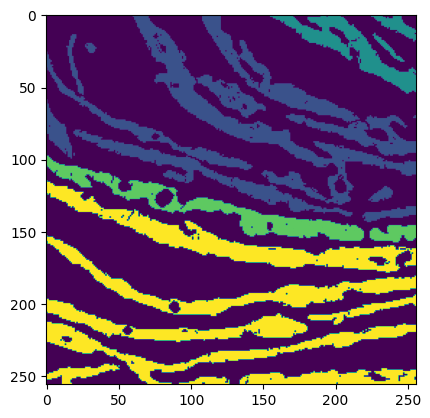

flood fill
flood fill
flood fill
flood fill
flood fill
flood fill
flood fill
flood fill
flood fill
flood fill
flood fill
flood fill
flood fill
flood fill
flood fill
flood fill
flood fill


In [119]:
current_directory = os.getcwd()
file_path = f'output/volumetric_labels/{x}_{y}_{z}_xyz_{chunk_size}_chunk_{scroll_name}_vol_label.nrrd'
output_path = os.path.join(current_directory, file_path)
label_save_test, _ = nrrd.read(output_path)
print(label_save_test.shape, label_save_test.dtype)
plt.imshow(label_save_test[0])  # Display the first slice of the saved label data